**CURSO**: Análisis Geoespacial, Departamento de Geociencias y Medio Ambiente, Universidad Nacional de Colombia - sede Medellín <br/>
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources: [Spatial Data Science](https://keen-swartz-3146c4.netlify.app/) by Edzer Pebesma & Roger Bivand, [Introduction to Python GIS](https://automating-gis-processes.github.io/CSC18/lessons/L1/Intro-Python-GIS.html) and the courses  and book open and freely published by [Dani Arribas-Bel](http://darribas.org/) -  University of Liverpool & - Sergio Rey - [Center for Geospatial Sciences, University of California, Riverside](http://spatial.ucr.edu/peopleRey.html). Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions. 

# Spatial data engineering
Real world datasets are messy. There is no way around it: datasets have "holes" (missing data), the amount of formats in which data can be stored is endless, and the best structure to share data is not always the optimum to analyze them, hence the need to [munge](http://dictionary.reference.com/browse/munge) them. As has been correctly pointed out in many outlets ([e.g.](http://www.nytimes.com/2014/08/18/technology/for-big-data-scientists-hurdle-to-insights-is-janitor-work.html?_r=0)), much of the time spent in what is called (Geo-) Data Science is related not only to sophisticated modeling and insight, but has to do with much more basic and less exotic tasks such as obtaining data, processing, turning them into a shape that makes analysis possible, and exploring it to get to know their basic properties. 

For how labor intensive and relevant this aspect is, there is surprisingly very little published on patterns, techniques, and best practices for quick and efficient data cleaning, manipulation, and transformation. In this session, you will use a few real world datasets and learn how to process them into Python so they can be transformed and manipulated, if necessary, and analyzed. For this, we will introduce some of the bread and butter of data analysis and scientific computing in Python. These are fundamental tools that are constantly used in almost any task relating to data analysis.

In [ ]:
# This ensures visualizations are plotted inside the notebook
%matplotlib inline

import os              # This provides several system utilities
import pandas as pd    # This is the workhorse of data munging in Python
import seaborn as sns  # This allows us to efficiently and beautifully plot

import warnings
warnings.filterwarnings('ignore')

## Geometric Objects

The most fundamental geometric objects are Points, Lines and Polygons which are the basic ingredients when working with spatial data in vector format. Python has a specific module called **Shapely** that can be used to create and work with Geometric Objects. There are many useful functionalities that you can do with Shapely such as:

* Create a Line or Polygon from a Collection of Point geometries
* Calculate areas/length/bounds etc. of input geometries
* Make geometric operations based on the input geometries such as Union, Difference, Distance etc.
* Make spatial queries between geometries such Intersects, Touches, Crosses, Within etc.

Geometric Objects consist of coordinate tuples where:

* Point -object represents a single point in space. Points can be either two-dimensional (x, y) or three dimensional (x, y, z).
* LineString -object (i.e. a line) represents a sequence of points joined together to form a line. Hence, a line consist of a list of at least two coordinate tuples
* Polygon -object represents a filled area that consists of a list of at least three coordinate tuples that forms the outerior ring and a (possible) list of hole polygons.

It is also possible to have a collection of geometric objects (e.g. Polygons with multiple parts):

* MultiPoint -object represents a collection of points and consists of a list of coordinate-tuples
* MultiLineString -object represents a collection of lines and consists of a list of line-like sequences
* MultiPolygon -object represents a collection of polygons that consists of a list of polygon-like sequences that construct from exterior ring and (possible) hole list tuples

### The shapely library
The individual geometry objects are provided by the shapely library:
- If you access a single geometry of a GeoDataFrame, you get a shapely geometry object
 -Those objects have similar functionality as geopandas objects (GeoDataFrame/GeoSeries). For example:
`single_shapely_object.distance(other_point)` -> distance between two points
`geodataframe.distance(other_point)` -> distance for each point in the geodataframe to the other point

See http://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html#sphx-glr-gallery-create-geopandas-from-pandas-py for full example

In [ ]:
from shapely.geometry import Point, LineString, Polygon

In [ ]:
# Create Point geometric object(s) with coordinates
point1 = Point(2.2, 4.2)
point2 = Point(7.2, -25.1)
point3 = Point(9.26, -2.456)
point3D = Point(9.26, -2.456, 0.57)

In [ ]:
print(type(point3D))

<class 'shapely.geometry.point.Point'>


In [ ]:
print(point1.coords.xy)
print(point1.y)
print(point1.x)

(array('d', [2.2]), array('d', [4.2]))
4.2
2.2


In [ ]:
# Calculate the distance between point1 and point2
point_dist = point1.distance(point2)
print(point_dist)

In [ ]:
# Create a LineString from our Point objects
line = LineString([point1, point2, point3])

# It is also possible to use coordinate tuples having the same outcome
line2 = LineString([(2.2, 4.2), (7.2, -25.1), (9.26, -2.456)])

In [ ]:
type(line2)

In [ ]:
# Get the lenght of the line
print(line.length)

# Get the coords
print(line.coords.xy)

# Get the centroid
print(line.centroid)

In [ ]:
# Create a Polygon from the coordinates
poly = Polygon([(2.2, 4.2), (7.2, -25.1), (9.26, -2.456)])
poly2 = Polygon([[p.x, p.y] for p in [point1, point2, point3]])

In [ ]:
type(poly2)

In [ ]:
# Get the centroid of the Polygon
print(poly.centroid)
# Get the area of the Polygon
print(poly2.area)        # cuáles son las unidades?
# Get the bounds of the Polygon (i.e. bounding box)
print(poly.bounds)

## Un/tidy data

It is often said that 80% of data analysis is spent on the process of cleaning and preparing the data. Once you can read your data in, explore specific cases, and have a first visual approach to the entire set, the next step can be preparing it for more sophisticated analysis. Maybe you are thinking of modeling it through regression, or on creating subgroups in the dataset with particular characteristics, or maybe you simply need to present summary measures that relate to a slightly different arrangement of the data than you have been presented with.

For all these cases, you first need what statistician, and general R wizard, Hadley Wickham calls **tidy data**. The general idea to "tidy" your data is to convert them from whatever structure they were handed in to you into one that allows convenient and standardized manipulation, and that supports directly inputting the data into what he calls "*tidy*" analysis tools. But, at a more practical level, what is exactly *"tidy data"*? In Wickham's own words:

> *Tidy data is a standard way of mapping the meaning of a dataset to its structure. A dataset is
messy or tidy depending on how rows, columns and tables are matched up with observations,
variables and types.*

Tidy datasets and tidy tools work hand in hand to make data analysis easier, allowing you to focus on the interesting domain problem, not on the uninteresting logistics of data.

He then goes on to list the three fundamental characteristics of *"tidy data"*:

1. Each variable forms a column.
1. Each observation forms a row.
1. Each type of observational unit forms a table.

<center><img src="https://images.squarespace-cdn.com/content/v1/5b872f96aa49a1a1da364999/1572008171822-KJ0300DR4KCHW8NUUN1N/ke17ZwdGBToddI8pDm48kP0H4u0KUkchoILChBGMIUUUqsxRUqqbr1mOJYKfIPR7LoDQ9mXPOjoJoqy81S2I8N_N4V1vUb5AoIIIbLZhVYy7Mythp_T-mtop-vrsUOmeInPi9iDjx9w8K4ZfjXt2dskF1CFdD1ghxEpYxbqRasKlXJQr8mv4xxZBDj9ez2c1CjLISwBs8eEdxAxTptZAUg/image.png?format=1500w" width="1000"></center>

If you are further interested in the concept of *"tidy data"*, I recommend you check out the [original paper](http://www.jstatsoft.org/v59/i10/) (open access) and the [public repository](https://github.com/hadley/tidy-data) associated with it.

<center><img src="https://images.squarespace-cdn.com/content/v1/5b872f96aa49a1a1da364999/1572032408033-E3XJOTD0M1DINAU5G54Z/ke17ZwdGBToddI8pDm48kNvT88LknE-K9M4pGNO0Iqd7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QPOohDIaIeljMHgDF5CVlOqpeNLcJ80NK65_fV7S1USOFn4xF8vTWDNAUBm5ducQhX-V3oVjSmr829Rco4W2Uo49ZdOtO_QXox0_W7i2zEA/tidy.jpg?format=1500w" width="1000"></center>

Let us bring in the concept of "*tidy data*" to our own Liverpool dataset. First, remember its structure:

## Dataset

We will be exploring some of the characteristics of the population in Liverpool. To do that, we will use a dataset that contains population counts, split by ethnic origin. These counts are aggregated at the [Lower Layer Super Output Area](http://www.ons.gov.uk/methodology/geography/ukgeographies/censusgeography#output-area-oa) (LSOA from now on). LSOAs are an official Census geography defined by the Office of National Statistics that is small enough to create variation within cities, but large enough also to preserve privacy. For that reason, many data products (Census, deprivation indices, etc.) use LSOAs as one of their main geographies.

You can read this file from its local repository or from its web location in the following way:

In [ ]:
f="https://darribas.org/gds_course/content/data/liv_pop.csv"

In [ ]:
# Read table
db = pd.read_csv(f, index_col="GeographyCode")

In [ ]:
db.head()

,Europe,Africa,Middle East and Asia,The Americas and the Caribbean,Antarctica and Oceania
GeographyCode,,,,,
E01006512,910,106,840,24,0
E01006513,2225,61,595,53,7
E01006514,1786,63,193,61,5
E01006515,974,29,185,18,2
E01006518,1531,69,73,19,4


In [ ]:
db["Total"]=db.sum(axis=1)
db.head(2)

,Europe,Africa,Middle East and Asia,The Americas and the Caribbean,Antarctica and Oceania,Total
GeographyCode,,,,,,
E01006512,910,106,840,24,0,1880
E01006513,2225,61,595,53,7,2941


Thinking through *tidy* lenses, this is not a tidy dataset. It is not so for each of the three conditions:

* Starting by the last one (*each type of observational unit forms a table*), this dataset actually contains not one but two observational units: the different areas of Liverpool, captured by `GeographyCode`; *and* subgroups of an area. To *tidy* up this aspect, we can create two different tables:

In [ ]:
# Assign column `Total` into its own as a single-column table
db_totals = db[['Total']]
db_totals.head()

,Total
GeographyCode,
E01006512,1880
E01006513,2941
E01006514,2108
E01006515,1208
E01006518,1696


In [ ]:
# Create a table `db_subgroups` that contains every column in `db` without `Total`
db_subgroups = db.drop('Total', axis=1)
db_subgroups.head()

,Europe,Africa,Middle East and Asia,The Americas and the Caribbean,Antarctica and Oceania
GeographyCode,,,,,
E01006512,910,106,840,24,0
E01006513,2225,61,595,53,7
E01006514,1786,63,193,61,5
E01006515,974,29,185,18,2
E01006518,1531,69,73,19,4


Note we use `drop` to exclude "Total", but we could also use a list with the names of all the columns to keep. Additionally, notice how, in this case, the use of `drop` (which leaves `db` untouched) is preferred to that of `del` (which permanently removes the column from `db`).

At this point, the table `db_totals` is tidy: every row is an observation, every table is a variable, and there is only one observational unit in the table.

The other table (`db_subgroups`), however, is not entirely tidied up yet: there is only one observational unit in the table, true; but every row is not an observation, and there are variable values as the names of columns (in other words, every column is not a variable). To obtain a fully tidy version of the table, we need to re-arrange it in a way that every row is a population subgroup in an area, and there are three variables: `GeographyCode`, population subgroup, and population count (or frequency). 

Because this is actually a fairly common pattern, there is a direct way to solve it in `pandas`:

In [ ]:
tidy_subgroups = db_subgroups.stack()
tidy_subgroups.head(10)

GeographyCode                                
E01006512      Europe                             910
               Africa                             106
               Middle East and Asia               840
               The Americas and the Caribbean      24
               Antarctica and Oceania               0
E01006513      Europe                            2225
               Africa                              61
               Middle East and Asia               595
               The Americas and the Caribbean      53
               Antarctica and Oceania               7
dtype: int64

The method `stack`, well, "stacks" the different columns into rows. This fixes our "tidiness" problems but the type of object that is returning is not a `DataFrame`:

In [ ]:
type(tidy_subgroups)

pandas.core.series.Series

It is a `Series`, which really is like a `DataFrame`, but with only one column. The additional information (`GeographyCode` and population group) are stored in what is called an multi-index. We will skip these for now, so we would really just want to get a `DataFrame` as we know it out of the `Series`. This is also one line of code away:

In [ ]:
# Unfold the multi-index into different, new columns
tidy_subgroupsDF = tidy_subgroups.reset_index()
tidy_subgroupsDF.head(10)

,GeographyCode,level_1,0
0,E01006512,Europe,910
1,E01006512,Africa,106
2,E01006512,Middle East and Asia,840
3,E01006512,The Americas and the Caribbean,24
4,E01006512,Antarctica and Oceania,0
5,E01006513,Europe,2225
6,E01006513,Africa,61
7,E01006513,Middle East and Asia,595
8,E01006513,The Americas and the Caribbean,53
9,E01006513,Antarctica and Oceania,7


To which we can apply to renaming to make it look better:

In [ ]:
tidy_subgroupsDF = tidy_subgroupsDF.rename(columns={'level_1': 'Subgroup', 0: 'Freq'})
tidy_subgroupsDF.head()

,GeographyCode,Subgroup,Freq
0,E01006512,Europe,910
1,E01006512,Africa,106
2,E01006512,Middle East and Asia,840
3,E01006512,The Americas and the Caribbean,24
4,E01006512,Antarctica and Oceania,0


Now our table is fully tidied up!

### Grouping, transforming, aggregating

One of the advantage of tidy datasets is they allow to perform advanced transformations in a more direct way. One of the most common ones is what is called "group-by" operations. Originated in the world of databases, these operations allow you to group observations in a table by one of its labels, index, or category, and apply operations on the data group by group. 

For example, given our tidy table with population subgroups, we might want to compute the total sum of population by each group. This task can be split into two different ones:

* Group the table in each of the different subgroups.
* Compute the sum of `Freq` for each of them.

To do this in `pandas`, meet one of its workhorses, and also one of the reasons why the library has become so popular: the `groupby` operator.

In [ ]:
pop_grouped = tidy_subgroupsDF.groupby('Subgroup')
pop_grouped

The object `pop_grouped` still hasn't computed anything, it is only a convenient way of specifying the grouping. But this allows us then to perform a multitude of operations on it. For our example, the sum is calculated as follows:

In [ ]:
pop_grouped.sum()

,Freq
Subgroup,
Africa,8886
Antarctica and Oceania,581
Europe,435790
Middle East and Asia,18747
The Americas and the Caribbean,2410


Similarly, you can also obtain a summary of each group:

In [ ]:
pop_grouped.describe()

Freq                                  \
                                count         mean         std    min   
Subgroup                                                                
Africa                          298.0    29.818792   51.606065    0.0   
Antarctica and Oceania          298.0     1.949664    2.168216    0.0   
Europe                          298.0  1462.382550  248.673290  731.0   
Middle East and Asia            298.0    62.909396  102.519614    1.0   
The Americas and the Caribbean  298.0     8.087248    9.397638    0.0   

                                                                  
                                    25%     50%      75%     max  
Subgroup                                                          
Africa                             7.00    14.0    30.00   484.0  
Antarctica and Oceania             0.00     1.0     3.00    11.0  
Europe                          1331.25  1446.0  1579.75  2551.0  
Middle East and Asia              16.00    33.5    62.75   840.0  
The Americas and the Caribbean     2.00     5.0    10.00    61.0

## [Series & Dataframes](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html)

**Series** is a one-dimensional labeled array capable of holding any data type (integers, strings, floating point numbers, Python objects, etc.). The axis labels are collectively referred to as the index. **DataFrames** is a 2-dimensional labeled data structure with columns of potentially different types. You can think of it like a spreadsheet or SQL table, or a dict of Series objects. It is generally the most commonly used pandas object. Like Series, DataFrame accepts many different kinds of input:

<center><img src="https://www.datasciencemadesimple.com/wp-content/uploads/2020/05/create-series-in-python-pandas-0.png" width="1000"></center>

* Dict of 1D ndarrays, lists, dicts, or Series
* 2-D numpy.ndarray
* Structured or record ndarray
* A Series
* Another DataFrame

Along with the data, you can optionally pass index (row labels) and columns (column labels) arguments. If you pass an index and / or columns, you are guaranteeing the index and / or columns of the resulting DataFrame. Thus, a dict of Series plus a specific index will discard all data not matching up to the passed index.

<center><img src="https://www.w3resource.com/w3r_images/pandas-data-structure.svg" width="1000"></center>

### GeoPandas: Creating a geodataframe
Aunque cada una de las bases de datos presenta códigos que relacionan los datos con su localización, esto no significa que se entiendan como datos espaciales; al menos para ser trabajados con la mayoría de programas espaciales.  Como se puede observar corresponden a estructuras tipo DataFrames en Python. Para transformar estas bases de datos a información espacial, denominada GeoDataFrames en Python, se requiere una transformación.

A **GeoDataFrame** contains a tabular, geospatial dataset:

* It has a **'geometry' column** that holds the geometry information (or features in GeoJSON).
* The other columns are the **attributes** (or properties in GeoJSON) that describe each of the geometries

Such a `GeoDataFrame` is just like a pandas `DataFrame`, but with some additional functionality for working with geospatial data:

* A `.geometry` attribute that always returns the column with the geometry information (returning a GeoSeries). The column name itself does not necessarily need to be 'geometry', but it will always be accessible as the `.geometry` attribute.
* It has some extra methods for working with spatial data (area, distance, buffer, intersection, ...), which we will see in later notebooks

Points are the simplest type of feature in that they do not have any dimension, only a pair of coordinates attached to them. This means that points can sometimes be stored in a non-geographic table, simply using one column for each coordinate. The data is stored as a comma-separated value table, or .csv:

* We use geopandas points_from_xy() to transform Longitude and Latitude into a list of shapely.Point objects and set it as a geometry while creating the GeoDataFrame.

* What we are interested in is the latitude and longitude columns of the dataset. 

### Constructing a GeoDataFrame manually

In [3]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [9]:
b=gpd.GeoDataFrame({
    'geometry': [Point(1, 1), Point(2, 2)],
    'attribute1': [1, 2],
    'attribute2': [0.1, 0.2]})
b

,geometry,attribute1,attribute2
0,POINT (1.00000 1.00000),1,0.1
1,POINT (2.00000 2.00000),2,0.2


In [10]:
type(b)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

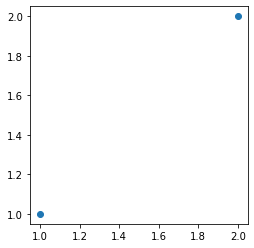

In [11]:
b.plot()

In [13]:
print(b.crs)

None


### Creating a GeoDataFrame from a dataframe
For example, if you have lat/lon coordinates in two columns

In [16]:
import pandas as pd
df = pd.DataFrame(
    {'City': ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'],
     'Country': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela'],
     'Latitude': [-34.58, -15.78, -33.45, 4.60, 10.48],
     'Longitude': [-58.66, -47.91, -70.66, -74.08, -66.86]})
df

,City,Country,Latitude,Longitude
0,Buenos Aires,Argentina,-34.58,-58.66
1,Brasilia,Brazil,-15.78,-47.91
2,Santiago,Chile,-33.45,-70.66
3,Bogota,Colombia,4.60,-74.08
4,Caracas,Venezuela,10.48,-66.86


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   City       5 non-null      object 
 1   Country    5 non-null      object 
 2   Latitude   5 non-null      float64
 3   Longitude  5 non-null      float64
dtypes: float64(2), object(2)
memory usage: 288.0+ bytes


<AxesSubplot:>

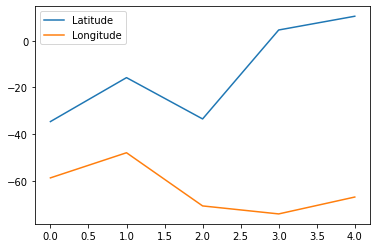

In [18]:
df.plot()

In [20]:
df['Coordinates']  = list(zip(df['Longitude'], df.Latitude))
df

,City,Country,Latitude,Longitude,Coordinates
0,Buenos Aires,Argentina,-34.58,-58.66,"(-58.66, -34.58)"
1,Brasilia,Brazil,-15.78,-47.91,"(-47.91, -15.78)"
2,Santiago,Chile,-33.45,-70.66,"(-70.66, -33.45)"
3,Bogota,Colombia,4.60,-74.08,"(-74.08, 4.6)"
4,Caracas,Venezuela,10.48,-66.86,"(-66.86, 10.48)"


In [21]:
df['Coordinates'] = df['Coordinates'].apply(Point)
df

,City,Country,Latitude,Longitude,Coordinates
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66 -34.58)
1,Brasilia,Brazil,-15.78,-47.91,POINT (-47.91 -15.78)
2,Santiago,Chile,-33.45,-70.66,POINT (-70.66 -33.45)
3,Bogota,Colombia,4.60,-74.08,POINT (-74.08 4.6)
4,Caracas,Venezuela,10.48,-66.86,POINT (-66.86 10.48)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   City         5 non-null      object 
 1   Country      5 non-null      object 
 2   Latitude     5 non-null      float64
 3   Longitude    5 non-null      float64
 4   Coordinates  5 non-null      object 
dtypes: float64(2), object(3)
memory usage: 328.0+ bytes


In [26]:
gdf = gpd.GeoDataFrame(df, geometry='Coordinates')
gdf

,City,Country,Latitude,Longitude,Coordinates
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66000 -34.58000)
1,Brasilia,Brazil,-15.78,-47.91,POINT (-47.91000 -15.78000)
2,Santiago,Chile,-33.45,-70.66,POINT (-70.66000 -33.45000)
3,Bogota,Colombia,4.60,-74.08,POINT (-74.08000 4.60000)
4,Caracas,Venezuela,10.48,-66.86,POINT (-66.86000 10.48000)


In [27]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

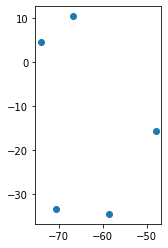

In [28]:
gdf.plot()

In [29]:
print(gdf.crs)

None


See http://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html#sphx-glr-gallery-create-geopandas-from-pandas-py for full example

### Creating a GeoDataFrame from a existing DataFrame

In [30]:
import pandas as pd
url="https://geographicdata.science/book/_downloads/7fb86b605af15b3c9cbd9bfcbead23e9/tokyo_clean.csv"
df = pd.read_csv(url)
df.head()

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06


In [31]:
type(df)

pandas.core.frame.DataFrame

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               10000 non-null  object 
 1   longitude             10000 non-null  float64
 2   latitude              10000 non-null  float64
 3   date_taken            10000 non-null  object 
 4   photo/video_page_url  10000 non-null  object 
 5   x                     10000 non-null  float64
 6   y                     10000 non-null  float64
dtypes: float64(4), object(3)
memory usage: 547.0+ KB


Many point datasets are provided in this format. To make the most of them, it is convenient to convert them into `GeoDataFrame` tables. There are two steps involved in this process:

1. Turn coordinates into geometries:

In [33]:
geo = gpd.points_from_xy(x=df["longitude"],y=df["latitude"], crs="EPSG:4326")

In [35]:
geo

<GeometryArray>
[  <POINT (139.7 35.674)>, <POINT (139.767 35.709)>, <POINT (139.766 35.694)>,
 <POINT (139.784 35.549)>, <POINT (139.769 35.672)>, <POINT (139.647 35.548)>,
 <POINT (139.699 35.675)>, <POINT (139.775 35.627)>, <POINT (139.614 35.662)>,
 <POINT (139.789 35.713)>,
 ...
 <POINT (139.766 35.672)>, <POINT (139.646 35.606)>,  <POINT (139.799 35.68)>,
  <POINT (139.77 35.699)>, <POINT (139.794 35.629)>, <POINT (139.583 35.533)>,
 <POINT (139.749 35.697)>,   <POINT (139.77 35.67)>, <POINT (139.739 35.642)>,
  <POINT (139.76 35.687)>]
Length: 10000, dtype: geometry

2. Create a `GeoDataFrame` object:

In [36]:
gdf = gpd.GeoDataFrame(df, geometry=geo)

In [ ]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [37]:
print(gdf.crs)

EPSG:4326


In [38]:
gdf.head(2)

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y,geometry
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06,POINT (139.70050 35.67400)
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06,POINT (139.76652 35.70909)


Otra forma de hacerlo en una sola linea de código es:

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))
gdf.head(2)

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y,geometry
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06,POINT (139.70050 35.67400)
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06,POINT (139.76652 35.70909)


<AxesSubplot:>

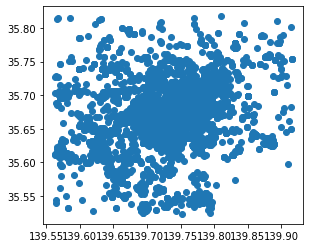

In [ ]:
gdf.plot()

* Que diferencia tienen estas bases de datos espacialmente?

* Cual es la diferencia entre un DataFrame y un GeoDataFrame?

### Creating geometries into a GeoDataFrame
Since geopandas takes advantage of Shapely geometric objects it is possible to create a Shapefile from a scratch by passing Shapely’s geometric objects into the GeoDataFrame. This is useful as it makes it easy to convert e.g. a text file that contains coordinates into a Shapefile.

Let’s create an empty GeoDataFrame.

In [ ]:
# Create an empty geopandas GeoDataFrame
newdata = gpd.GeoDataFrame()

In [ ]:
# Let's see what's inside
newdata

""


The GeoDataFrame is empty since we haven’t placed any data inside. Let’s create a new column called geometry that will contain our Shapely objects:

In [ ]:
# Create a new column called 'geometry' to the GeoDataFrame
newdata['geometry'] = None

# Let's see what's inside
newdata

,geometry


Now we have a geometry column in our GeoDataFrame but we don’t have any data yet. Let’s create a Shapely Polygon representing the Helsinki Senate square that we can insert to our GeoDataFrame:

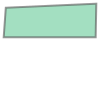

In [ ]:
# Coordinates of the Helsinki Senate square in Decimal Degrees
coordinates = [(24.950899, 60.169158), (24.953492, 60.169158), (24.953510, 60.170104), (24.950958, 60.169990)]

# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)

# Let's see what we have
poly

Ok, so now we have appropriate Polygon -object. Let’s insert the polygon into our ‘geometry’ column in our GeoDataFrame:

In [ ]:
# Insert the polygon into 'geometry' -column at index 0
newdata.loc[0, 'geometry'] = poly

# Let's see what we have now
newdata

,geometry
0,"POLYGON ((24.95090 60.16916, 24.95349 60.16916..."


In [ ]:
Let’s add another column to our GeoDataFrame called Location with text Senaatintori.

In [ ]:
# Add a new column and insert data
newdata.loc[0, 'Location'] = 'Senaatintori'

# Let's check the data
newdata

,geometry,Location
0,"POLYGON ((24.95090 60.16916, 24.95349 60.16916...",Senaatintori


It is useful to determine the coordinate reference system (projection) for the GeoDataFrame.

GeoDataFrame has a property called .crs that shows the coordinate system of the data which is empty (None) in our case since we are creating the data from the scratch:

In [ ]:
print(newdata.crs)

None


Let’s add a crs for our GeoDataFrame. A Python module called fiona has a nice function called from_epsg() for passing coordinate system for the GeoDataFrame. Next we will use that and determine the projection to WGS84 (epsg code: 4326):

In [ ]:
from fiona.crs import from_epsg
newdata.crs = from_epsg(4326)
newdata.crs

C:\Users\usuario\miniconda3\envs\spatial\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Geographic 2D CRS: +init=epsg:4326 +no_defs +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

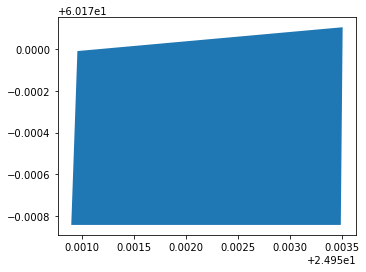

In [ ]:
newdata.plot()

## Feature Engineering
En aprendizaje automático y ciencia de datos, a menudo contamos con una gran cantidad de datos. De hecho, dado el conjunto de paquetes para consultar servicios de datos, los conjuntos de datos gratuitos y de código abierto, y la rápida y persistente recolección de datos geográficos, simplemente hay demasiados datos para representarlos de manera coherente en un único formato ordenado. Sin embargo, a menudo necesitamos ser capaces de construir características útiles a partir de este vasto y profundo océano de datos.

Cuando los datos están disponibles, pero aún no son directamente utilizables, la **ingeniería de características** ayuda a construir datos útiles para modelar un fenómeno de interés. En el aprendizaje automático tradicional, la ingeniería de características implica aplicar conocimientos adicionales del dominio a la información cruda para estructurarla de una manera que sea significativa para un modelo. A menudo, esto implica algún tipo de transformación del conjunto de datos original, un concepto bien estudiado tanto en la estadística clásica como en los métodos de aprendizaje automático. Aunque la ingeniería de características siempre se basa en este conocimiento implícito del dominio, es una parte extremadamente importante para adaptar los algoritmos de propósito general a problemas únicos o distintivos que enfrentan los científicos de datos en su día a día.

La geografía es una de las formas más de alta calidad y ubicuas de introducir conocimiento del dominio en un problema: todo tiene una posición tanto en el espacio como en el tiempo. Y, aunque los eventos que ocurren cerca uno del otro en el tiempo no necesariamente tienen una relación fundamental, las cosas que están cerca en el espacio a menudo están relacionadas. Por lo tanto, el espacio es la clave de vinculación definitiva, lo que nos permite conectar diferentes conjuntos de datos para mejorar nuestros modelos y predicciones. Esto significa que, incluso para datos "no geográficos" o **aspatiales**, puedes utilizar la ingeniería de características espaciales para crear características útiles y altamente relevantes para tu análisis.

En su esencia, la ingeniería de características espaciales es el proceso de desarrollar información adicional a partir de datos crudos utilizando conocimiento geográfico. Esta destilación de información puede ocurrir entre conjuntos de datos, donde se usa la geografía para vincular información de conjuntos de datos separados; o dentro de un conjunto de datos, donde la geografía puede ser utilizada para aumentar la información disponible para una muestra aprovechando las cercanas. Este tutorial está estructurado siguiendo esa distinción: para los casos en los que la geografía conecta diferentes conjuntos de datos, adoptamos el término **Map Matching**, frecuentemente utilizado en la industria; mientras que usamos el concepto espejo de **Map Synthesis** para describir el uso de la estructura geográfica para derivar nuevas características a partir de un conjunto de datos determinado. Técnicamente hablando, algunos de los métodos que revisamos son similares en ambos casos, o incluso los mismos; sin embargo, pueden aplicarse en el contexto de *emparejamiento* o *síntesis*, y los consideramos conceptualmente diferentes, de ahí su inclusión en ambas secciones.

A lo largo de esta parte del tutorial, utilizamos los precios nocturnos de alquiler de Airbnb en San Diego, así como conjuntos de datos auxiliares como la elevación o los datos demográficos del Censo.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd, pandas as pd, libpysal.weights as weights, contextily as ctx
from tobler.area_weighted import area_interpolate
import matplotlib.pyplot as plt
import cenpy
import numpy as np
import osmnx
import rasterio as rio
from rasterio.plot import show as rioshow

In [ ]:
airbnbs = gpd.read_file("https://geographicdata.science/book/_downloads/dcd429d1761a2d0efdbc4532e141ba14/regression_db.geojson")

In [ ]:
airbnbs.head(2)

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)


<AxesSubplot:>

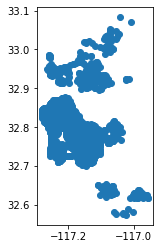

In [ ]:
airbnbs.plot()

At its core, spatial feature engineering is the process of developing additional information from raw data using geographic knowledge. This synthesis could occur between datasets, where geography is used to link samples in separate datasets together; or within datasets, where geography can be used to borrow information from nearby samples. Building linkages between datasets is often called **Map Matching**, while we use the term **Map Synthesis** to describe the use of geographical structure to derive new features from existing data. Both kinds of geographic feature engineering will be covered in this chapter, starting first with various methods for Map Matching when modelling Airbnb nightly rental prices in San Diego.

To help us discuss this, a vocabulary is helpful. We will cover a few different kinds of features in this chapter, both of which can be constructed in either Map Synthesis or Map Matching operations:

* A **spatial summary feature** measures the attributes of observations that have some pre-specified spatial relationship with our target observations. This includes

    * taking the average or median value of features within a neighborhood of each target observation.

    * the spatial lag is a kind of spatial summary feature, since it reflects the average value of the data in the neighborhood around each point.

    * Other kinds of spatial summary features might include the count of observations within a given distance or the standard deviation of ten nearest observations.

    * Summary features generally include interpolated features which involve a transfer of information from one spatial support to another, such as when the target locations are not the same as the locations in our anciliary data. Interpolated features become significantly more complex as well when the data is areal, as will be discussed later in this chapter.

* A **proximity feature** measures the distance from a target observation to some other observation or position in the map. This might be done in a map matching context, as we did before with the distance to Balboa Park, or it might be done in a map synthesis context by measuring the distance to the nearest other observation.

### Feature Engineering Using Map Matching

Space is the ultimate linkage key; map matching is all about exploiting this asset. Geographic information is collected at different scales, aggregated using bespoke geographic delineations, and ultimately stored in different datasets. Modelling and machine learning usually require the use of data aligned and coherently structured; to bring disparate geo-datasets together, the data scientist needs to be able to transfer information expressed for one geography into another. This is where map matching comes to rescue. By using geographical location, we can connect datasets that have no common key or that are otherwise completely unrelated. This is a “magic trick” that we can pull off because of location that would be much harder, or impossible, with data lacking spatial information.

The details, and difficulty, of this transfer of information from one geography to another one depend on the nature of the “source” and “target”, and on the precision with which we want to perform such transfer. In this context, there is always an inevitable trade-off between precission and sophistication: more precise transfer is usually possible at the expense of more advanced and involved techniques. Their additional cost in applying them, both in terms of cognitive load on the data scientist’s part or in terms of computation, must be weighted in on an individual basis: sometimes we need the best possible estimates, at all costs; sometimes “good enough” is, well, good enough.

In this section, we cover a few cases that we consider represent the most common and widely used approaches. We begin with situations where we have two point datasets and all we need to calculate are descriptive statistics of one dataset to the observations in the other. We swith the type of data and consider how to attach information from a continuous grid, stored in a raster file, to a set of points. Then we show the equivalent case for “moving” information for a polygon geography to a point dataset. These are all cases that, in their simplest form, involve mostly traditional GIS operations (e.g., buffer construction, spatial joins) and little in the way of statistical modelling. As an example of a case that is more involved, we cover the transfer of information from a polygon geography to another, different polygon geography. For this final case, but also as a more general comment, we try to include examples that capture the essence of the method, but keep the technique as simple as possible. For almost any of these cases we cover, the reader can find more sophisticated techniques that usually yield more accurate estimates. Where possible, we try to signpost these.

#### Counting nearby features¶

A first, conceptually straightforward, approach is to augment our dataset by counting how many points of a different dataset are in the vicinity of each observation. For example, we might want to know how many bars and restaurants each AirBnb has within a given radius. This count can then become an additional feature of our dataset, stored in a new column of airbnbs.

To obtain information on the location of restaurants and bars, we can download it from OpenStreetMap directly using osmnx. We first query all the points of interest (POIs) within the area our points cover, and then filter out everything except restaurants and bars. For that, we require a polygon that covers all our airbnbs points. We can recall that there are a few different hulls that can be used. We’ll use the Convex Hull here, which is the smallest convex polygon that covers all of the points in the set.

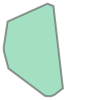

In [ ]:
airbnbs_ch = airbnbs.unary_union.convex_hull
airbnbs_ch

Using this polygon, we can use the osmnx package to fetch points of interest (POIs) from OpenStreetMap. We can make our request more manageable by only requesting points of interest that fall within specific categories. Below, we’ll request POIs within San Diego that are “restaurants” or “bars,” according to their metadata stored in OpenStreetMap.

In [ ]:
pois = osmnx.geometries_from_polygon(airbnbs_ch, tags={"amenity": ['restaurant', 'bar']})

In [ ]:
pois.sample(10)

amenity              cuisine  \
element_type osmid                                         
node         3048074973  restaurant                  NaN   
             478519118   restaurant                  NaN   
way          546280455   restaurant  burger;american;bar   
node         596605690   restaurant            breakfast   
             3884055550         bar                  NaN   
             6374952320  restaurant                  NaN   
             3884061449  restaurant              mexican   
way          31840741    restaurant                asian   
             31818773    restaurant               korean   
node         4018371645  restaurant                cuban   

                                                 name  \
element_type osmid                                      
node         3048074973  Parking for Chicken Pie Shop   
             478519118              Cafe Bella Italia   
way          546280455         Kaminski's Bar & Grill   
node         596605690           The Broken Yolk Cafe   
             3884055550   Carruth Cellars Wine Garden   
             6374952320              Craft & Commerce   
             3884061449                     El Camino   
way          31840741                             NaN   
             31818773                      Tofu House   
node         4018371645                 Embargo Grill   

                                                                  geometry  \
element_type osmid                                                           
node         3048074973                        POINT (-117.13544 32.75457)   
             478519118                         POINT (-117.24197 32.79927)   
way          546280455   POLYGON ((-117.05514 32.95534, -117.05513 32.9...   
node         596605690                         POINT (-117.15891 32.70907)   
             3884055550                        POINT (-117.17066 32.72749)   
             6374952320                        POINT (-117.16893 32.72077)   
             3884061449                        POINT (-117.17095 32.72940)   
way          31840741    POLYGON ((-117.08322 32.75683, -117.08340 32.7...   
             31818773    POLYGON ((-117.12724 32.91673, -117.12735 32.9...   
node         4018371645                        POINT (-117.22209 32.75516)   

                        diet:vegan diet:vegetarian created_by  addr:city  \
element_type osmid                                                         
node         3048074973        NaN             NaN        NaN        NaN   
             478519118         NaN             NaN        NaN        NaN   
way          546280455         NaN             NaN        NaN        NaN   
node         596605690         NaN             NaN        NaN  San Diego   
             3884055550        NaN             NaN        NaN  San Diego   
             6374952320        NaN             NaN        NaN        NaN   
             3884061449        NaN             NaN        NaN        NaN   
way          31840741          NaN             NaN        NaN        NaN   
             31818773          NaN             NaN        NaN  San Diego   
node         4018371645        NaN             NaN        NaN        NaN   

                        addr:housenumber addr:postcode  ... payment:notes  \
element_type osmid                                      ...                 
node         3048074973              NaN           NaN  ...           NaN   
             478519118               NaN           NaN  ...           NaN   
way          546280455               NaN           NaN  ...           NaN   
node         596605690               355         92101  ...           NaN   
             3884055550             2215         92101  ...           NaN   
             6374952320              NaN           NaN  ...           NaN   
             3884061449              NaN           NaN  ...           NaN   
way          31840741                NaN           NaN  ...           NaN   
  

This provides us with every location within our convex hull that is tagged as a “restaurant” or “bar” its metadata on OpenStreteMap. Overall, this provides us with about 1300 points of interest:

In [ ]:
pois.groupby('amenity').amenity.count()

amenity
bar            321
restaurant    1150
Name: amenity, dtype: int64

Once loaded into pois as a GeoDataFrame, let’s take a peek at their location, as compared with AirBnb spots:

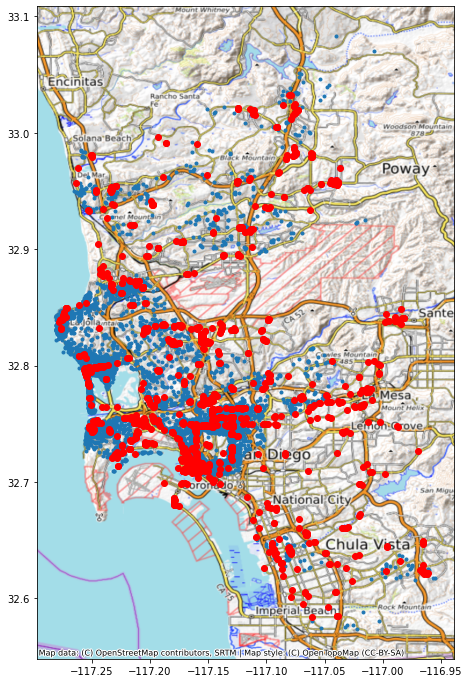

In [ ]:
f,ax = plt.subplots(1,figsize=(12, 12))
airbnbs.plot(ax=ax, marker='.')
pois.plot(ax=ax, color='r')
ctx.add_basemap(ax, crs=airbnbs.crs.to_string(), source=ctx.providers.OpenTopoMap)

Now, for some feature engineering, it may be extremely useful to know whether an Airbnb is located in a “hot” location, with a lot of restaurants and bars to choose from. Alternatively, if Airbnbs are very remote, they might not be as lucrative for short, expensive “city-break” reservations. That is, Airbnb users may decide to reserve stays where there are a lot of dining and drinking opportunities, and thus may be willing to pay more for the same accommodation. We might be able to predict prices better if we know about the drinking and dining scene near the Airbnb.

Thus, we can engineer features in the Airbnb data using the nearby POIs. To do this, we can create a new feature for the AirBnb dataset –that is, a new column in airbnbs– which incorporates information about how many POIs are nearby each property. This kind of “feature counting” is useful in applications where the mere presence of nearby features can affect the quantity we are modelling.

To do this kind of feature engineering, let us first walk through what we need to do at a conceptual level:

1. Decide what is nearby. This will dictate how far we go from each AirBnb when counting the number of “nearby” bars & restaurants. For this example, we will use 500 meter buffer, which is approximately the distance of a leisurely ten-minute walk.

2. For each AirBnb, determine whether POIs are within a leisurely 10-minute walk.

3. Count how many POIs are withing the specified radius of each AirBnb.

At the end of this procedure, we have the number of bars & restuarants that are within a leisurely walk of the AirBnb, which might be useful in predicting the price of each AirBnb.

With this, let us now translate the list above into code. For part 1., we need to be able to measure distances in metres. However, airbnbs is originally expressed in degrees, since it is provided in terms of locations in latitude and longitude:

In [ ]:
airbnbs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In addition, the pois are also provided in terms of their latitude & longitude:

In [ ]:
pois.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Therefore, we need to convert this into a coordinate system that is easier to work with. Here, we will use a projection common for mapping in California, the California Albers projection:

In [ ]:
airbnbs_albers = airbnbs.to_crs(epsg=3311)
pois_albers = pois.to_crs(epsg=3311)

With this, we can create the radius of 500m around each AirBnb. This is often called buffering, where a shape is dilated by a given radius

In [ ]:
airbnbs_albers['buffer_500m'] = airbnbs_albers.buffer(500)

In [ ]:
airbnbs_albers.head(2)

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,...,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry,buffer_500m
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,...,0,0,1,0,0,1,0,0,POINT (269312.639 -580195.744),"POLYGON ((269812.639 -580195.744, 269810.232 -..."
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,...,0,1,0,0,0,1,0,0,POINT (257694.376 -577191.922),"POLYGON ((258194.376 -577191.922, 258191.968 -..."


In [ ]:
airbnbs_albers.plot(column="buffer_500m")

Now, abb_buffer contains a 500-meter circle around each Airbnb.

Using these, we can count the number of POIs that are within these areas using a spatial join. Spatial joins link geometries based on spatial relationships (or predicates). Here, we need to know the relationship: pois within airbnb_buffers, where within is the predicate relating pois to airbnb_buffers. Predicates are not always reversible: no airbnb_buffer can be within a poi. In geopandas, we can compute all pairs of relations between the pois and airbnb_buffers efficiently using the sjoin function, which takes a predicate argument defining the requested relationship between the first & second argument.

For more detail related to GIS operation using Python, please go to [Introduction to Python GIS](https://automating-gis-processes.github.io/CSC18/index.html)

In [ ]:
airbnbs_albers.head(2)

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,...,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry,buffer_500m
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,...,0,0,1,0,0,1,0,0,POINT (269311.513 -580195.246),"POLYGON ((269811.513 -580195.246, 269809.105 -..."
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,...,0,1,0,0,0,1,0,0,POINT (257693.248 -577191.423),"POLYGON ((258193.248 -577191.423, 258190.840 -..."


In [ ]:
airbnbs_albers.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

In [ ]:
pois_albers.head(2)

,unique_id,osmid,element_type,amenity,cuisine,name,geometry,diet:vegan,diet:vegetarian,created_by,...,layer,payment:notes,height,owner,toilets:wheelchair,source:addr,old_name,fast_food,indoor,craft
0,node/273607070,273607070,node,restaurant,italian,Leucadia,POINT (260050.430 -568467.689),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/273607369,273607369,node,restaurant,sushi,Subarashi,POINT (260051.647 -568498.337),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(np.shape(airbnbs_albers))
print(np.shape(pois_albers))

(6110, 21)
(1322, 122)


In [ ]:
airbnbs_albers.set_geometry('buffer_500m')[['id','buffer_500m']]

,id,buffer_500m
0,6,"POLYGON ((269812.639 -580195.744, 269810.232 -..."
1,5570,"POLYGON ((258194.376 -577191.922, 258191.968 -..."
2,9553,"POLYGON ((268736.085 -580308.812, 268733.677 -..."
3,14668,"POLYGON ((267068.078 -560652.692, 267065.671 -..."
4,38245,"POLYGON ((261503.776 -581770.057, 261501.368 -..."
...,...,...
6105,13882013,"POLYGON ((261303.624 -567437.818, 261301.216 -..."
6106,13882245,"POLYGON ((266794.991 -585120.702, 266792.584 -..."
6107,13882335,"POLYGON ((269836.861 -581465.947, 269834.454 -..."
6108,13882606,"POLYGON ((267979.261 -584768.573, 267976.853 -..."


In [ ]:
joined = gpd.sjoin(pois_albers, airbnbs_albers.set_geometry('buffer_500m')[['id','buffer_500m']],op='within')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
np.shape(joined)

(60338, 128)

In [ ]:
joined.sample(2)

amenity cuisine                 name  \
element_type osmid                                            
node         365317994     bar     NaN            The Grape   
             365318089     bar     NaN  The Holding Company   

                                              geometry diet:vegan  \
element_type osmid                                                  
node         365317994  POINT (266629.907 -584715.510)        NaN   
             365318089  POINT (257879.173 -581252.925)        NaN   

                       diet:vegetarian created_by addr:city addr:housenumber  \
element_type osmid                                                             
node         365317994             NaN        NaN       NaN              813   
             365318089             NaN        NaN       NaN              NaN   

                       addr:postcode  ... height owner toilets:wheelchair  \
element_type osmid                    ...                                   
node         365317994           NaN  ...    NaN   NaN                NaN   
             365318089           NaN  ...    NaN   NaN                NaN   

                       source:addr fast_food indoor craft layer index_right  \
element_type osmid                                                            
node         365317994         NaN       NaN    NaN   NaN   NaN        5226   
             365318089         NaN       NaN    NaN   NaN   NaN        1327   

                              id  
element_type osmid                
node         365317994  13219303  
             365318089   4054211  

[2 rows x 128 columns]

The resulting joined object joined contains a row for every pair of POI and AirBnb that are linked. From there, we can apply a group-by operation, using the AirBnb ID, and count how many POIs each AirBnb has within 500m of distance:

In [ ]:
joined.groupby("id").size()

id
6           12
5570         7
9553        12
38245        1
69385        8
            ..
13882013     8
13882245    69
13882335     9
13882606     8
13882933     3
Length: 4615, dtype: int64

In [ ]:
poi_count = joined.groupby("id")["name"].count().to_frame('poi_count')
poi_count.head()

,poi_count
id,
6,12
5570,7
9553,12
38245,0
69385,8


The resulting Series is indexed on the AirBnb IDs, so we can assign it to the original airbnbs table. In this case, we know by construction that missing AirBnbs in poi_count do not have any POI within 500m, so we can fill missing values in the column with zeros

In [ ]:
airbnbs_w_counts = airbnbs_albers.merge(poi_count, left_on='id', right_index=True).fillna({"poi_count": 0})

In [ ]:
airbnbs_w_counts.head(2)

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,...,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry,buffer_500m,poi_count
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,...,0,1,0,0,1,0,0,POINT (269312.639 -580195.744),"POLYGON ((269812.639 -580195.744, 269810.232 -...",12
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,...,1,0,0,0,1,0,0,POINT (257694.376 -577191.922),"POLYGON ((258194.376 -577191.922, 258191.968 -...",7


We can visualise now the distribution of counts to get a sense of how “well-served” AirBnb properties are arranged over space (for good measure, we’ll also add a legendgram):

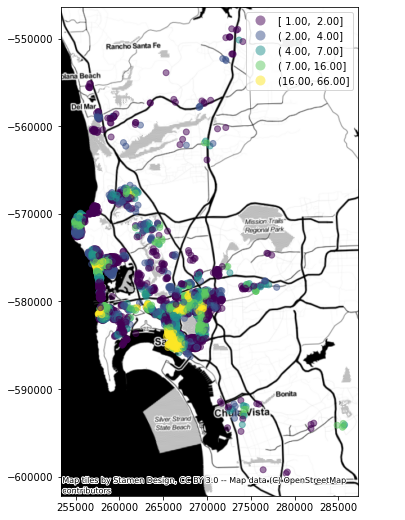

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))
airbnbs_w_counts.plot(column="poi_count",
                      scheme="quantiles",
                      alpha=0.5,
                      legend=True,
                      ax=ax
                     )
ctx.add_basemap(ax, 
                       crs=airbnbs_albers.crs.to_string(), 
                       source=ctx.providers.Stamen.Toner
                      )

In [ ]:
airbnbs_w_counts.head(2)

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,...,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry,buffer_500m,poi_count
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,...,0,1,0,0,1,0,0,POINT (269311.513 -580195.246),"POLYGON ((269811.513 -580195.246, 269809.105 -...",12
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,...,1,0,0,0,1,0,0,POINT (257693.248 -577191.423),"POLYGON ((258193.248 -577191.423, 258190.840 -...",7


#### Assigning point values from surfaces

We have just seen how to count points around each observation in a point dataset. In other cases, we might be confronted with a related but different challenge: transfering the value of a particular point in a surface to a point in a different dataset.

To make this more accessible, let us illustrate the context with an example question: what is the elevation of each AirBnb property? To answer this question, we require, at least, the following:

1. A sample of AirBnb property locations.

2. A dataset of elevation. We will use here the NASA DEM surface for the San Diego area.

Let us bring the elevation surface:

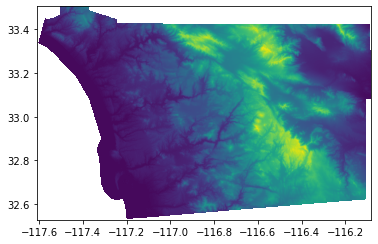

<AxesSubplot:>

In [ ]:
dem = rio.open("https://geographicdata.science/book/_downloads/9287b38e4d53d9d500df367d8e678465/nasadem_sd.tif")
rioshow(dem)

In [ ]:
dem.crs

CRS.from_epsg(4326)

In [ ]:
type(dem)

rasterio.io.DatasetReader

We have opened the file with rasterio, which has not read the entire dataset just yet. This feature allows us to use this approach with files that are potentially very large, as only requested data is read into memory.

To extract a discrete set of values from the elevation surface in dem, we can use sample. For a single location, this is how it works:

In [ ]:
list(dem.sample([(-117.24592208862305, 32.761619109301606)]))

[array([7], dtype=int16)]

Now, we can apply this logic to a sequence of coordinates. For that, we need to extract them from the geometry object:

In [ ]:
abb_xys = pd.DataFrame({"X": airbnbs.geometry.x, 
                            "Y": airbnbs.geometry.y
                           }).to_records(index=False)
abb_xys

rec.array([(-117.12970522, 32.75399316), (-117.25253317, 32.78421162),
           (-117.14120839, 32.75326632), ...,
           (-117.12985693, 32.74252225), (-117.15069763, 32.71321916),
           (-117.21813283, 32.92168793)],
          dtype=[('X', '<f8'), ('Y', '<f8')])

In [ ]:
type(abb_xys)

numpy.recarray

In [ ]:
elevation = pd.DataFrame(dem.sample(abb_xys), columns=["Elevation"], index=airbnbs.index)
elevation.head()

,Elevation
0,112
1,3
2,99
3,114
4,30


Now we have a table with the elevation of each AirBnb property, we can plot the site elevations on a map for visual inspection:

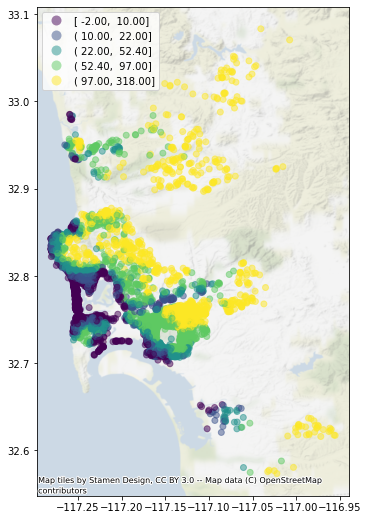

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))
airbnbs.join(elevation).plot(column="Elevation",
             scheme="quantiles",
             legend=True,
             alpha=0.5,
             ax=ax
            )
ctx.add_basemap(ax, 
                       crs=airbnbs.crs.to_string(), 
                       source=ctx.providers.Stamen.TerrainBackground,
                       alpha=0.5
                      )

#### Polygon to point

We now move on to a case where the information we are interested in matching to our set of points is stored for a polygon geography. For example, we would like to know the population density of the neighborhood in which each AirBnb is located. To determine density, we will download population estimates at the Census tract level, and “transfer” those estimates over to each AirBnb point. Geographically, the only challenge here is finding the containing polygon for each point, and then performing what is in spatial databases parlance known as a “spatial join”, by which we link the two layers through their spatial connection.

Let us pull down the number of inhabitants from the American Community Survey for tracts in San Diego:

In [ ]:
acs = cenpy.products.ACS()
sd_pop = acs.from_msa("San Diego, CA", level = "tract", variables=['B02001_001E'])

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
sd_pop["density"] = sd_pop["B02001_001E"]
sd_pop.head(2)

,GEOID,geometry,B02001_001E,NAME,state,county,tract,density
0,06073018511,"POLYGON ((-13063789.970 3922505.030, -13063789...",5205.0,"Census Tract 185.11, San Diego County, California",06,073,018511,5205.0
1,06073017701,"POLYGON ((-13059537.230 3907015.040, -13059431...",5299.0,"Census Tract 177.01, San Diego County, California",06,073,017701,5299.0


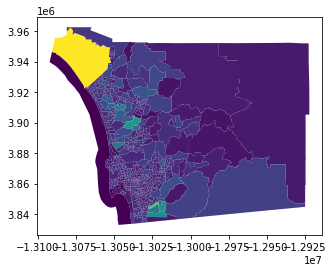

In [ ]:
sd_pop.plot('density');

In [ ]:
sd_pop.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
sd_pop.to_crs(epsg=3311).area

0      1.689368e+06
1      2.923198e+06
2      2.496942e+06
3      1.489584e+06
4      7.506380e+05
           ...     
623    2.102968e+06
624    6.234904e+06
625    4.047533e+07
626    4.284926e+07
627    1.294227e+09
Length: 628, dtype: float64

Now, to “transfer” density estimates to each AirBnb, we can rely on the spatial join in geopandas:

In [ ]:
j = gpd.sjoin(airbnbs, sd_pop.to_crs(airbnbs.crs))

The result is a table with one row per AirBnb and one column for each attribute we originally had for properties, as well as those of the tract where the area is located:

In [ ]:
j.head(2)

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,...,rt_Shared_room,geometry,index_right,GEOID,B02001_001E,NAME,state,county,tract,density
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,...,0,POINT (-117.12971 32.75399),501,06073001300,6102.0,"Census Tract 13, San Diego County, California",06,073,001300,6102.0
78,2,1.0,1.0,2.0,North Hills,0,2.414891,0,130.0,4.867534,...,0,POINT (-117.13288 32.74976),501,06073001300,6102.0,"Census Tract 13, San Diego County, California",06,073,001300,6102.0


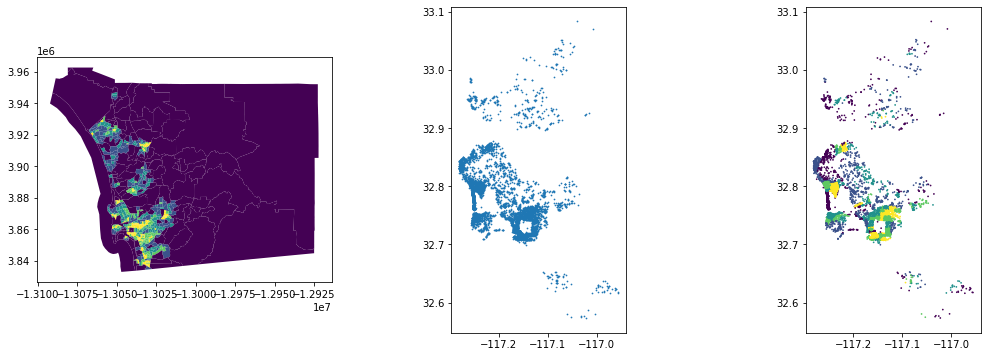

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))

sd_pop.plot(column="density", scheme="quantiles", ax=axs[0])

airbnbs.plot(ax=axs[1], markersize=0.5)

j.plot(column="density",
       scheme="quantiles",
       markersize=0.5,
       ax=axs[2]
      )

plt.show()

### Feature Engineering using Map Synthesis¶

Feature engineering with map matching is most helpful when you have additional information to use in the analysis. And, with the wealth of freely available data from censuses, satellites, and open volunteered geographic information vendors such as OpenStreetMap, map matching can be a very powerful tool for enriching and improving your analyses. However, it is sometimes also useful to only examine the data you’ve got, and use the spatial structure within to build better features or better models. While this might be done using spatially-explicit models, it is also possible to use map synthesis to build spatial feature and improve your predictions.

There is an extensive amount of map synthesis features. In addition to the two kinds of features discussed in map matching, there are other kinds of useful features that can be used in map synthesis that will be discussed below. First, we will return to spatial summary features. Second, we will examine some regionalization features, which detect and leverage geographical clusters in the data to improve prediction.

There is an extensive amount of map synthesis features. In addition to the two kinds of features discussed in map matching, there are other kinds of useful features that can be used in map synthesis that will be discussed below. First, we will return to spatial summary features. Second, we will examine some regionalization features, which detect and leverage geographical clusters in the data to improve prediction

#### Spatial Summary Features in Map Synthesis

Just like in map matching, you can use spatial summary features in map synthesis to make better predictions. One clear method involves constructing spatial summary measures of your training data. This is done in the same manner as in map matching, except we can now refer only to the data on hand. Thus, we may want to determine whether nearby Airbnbs are “competing” with each Airbnb. We might do this by finding the distance to the nearest Airbnb with the same number of bedrooms, since two nearby listings that also sleep the same number of people likely will compete with one another for tenants.

##### Distance buffers within a single table

We might do this by building a DistanceBand weight object, which considers Airbnb as “neighbors” if they are within the distance threshold.

In [ ]:
d500_w = weights.DistanceBand.from_dataframe(airbnbs_albers, threshold=500, silence_warnings=True)

Now, we can get the average size of surrounding Airbnbs directly as the spatial lag:

In [ ]:
d500_w.transform = 'r'

In [ ]:
local_average_bedrooms = weights.lag_spatial(d500_w, airbnbs_albers[['bedrooms']].values)

While related, these features contain quite distinct pieces of information, and both may prove useful in modelling:

Text(0, 0.5, "Average of nearby\n listings' bedrooms")

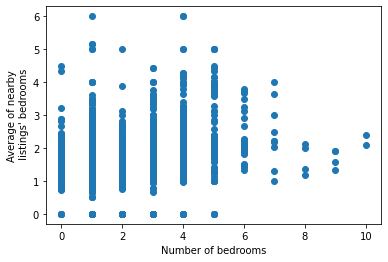

In [ ]:
plt.scatter(airbnbs_albers[['bedrooms']].values, local_average_bedrooms)
plt.xlabel("Number of bedrooms")
plt.ylabel("Average of nearby\n listings' bedrooms")

If we were instead interested in the most common number of bedrooms, rather than the average, we could use the lag_categorical function:

In [ ]:
local_mode = weights.lag_categorical(d500_w, airbnbs_albers[['bedrooms']].values)

Since we are now treating the number of bedrooms as a discrete feature, we can use a crosstab from pandas to examine the relationship between a listing and the typical size of listings nearby:

In [ ]:
crosstab = pd.crosstab(airbnbs_albers.bedrooms, local_mode.flatten())
crosstab.columns.name = "nearby"
crosstab

nearby,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
bedrooms,,,,,,,,
0.0,4,391,39,8,2,0,1,0
1.0,2,3066,213,33,20,4,0,0
2.0,1,979,267,12,3,1,0,0
3.0,1,425,168,35,12,3,0,0
4.0,1,165,58,10,31,6,2,0
5.0,0,52,15,2,10,19,0,0
6.0,0,12,10,0,4,2,1,0
7.0,0,5,1,2,1,0,0,1
8.0,0,3,1,0,0,0,0,0


If more complicated statistics are required. it can help to re-express the construction of summary statistics as a reduction of the adjacency list representation of our weights. To recap, the adjacency list is a pandas.DataFrame where each row contains a single link in our graph. It contains the identifier for some focal observation, the identifier for some neighbor observation, and a value for the weight of the link that connects the focal and neighbor:

In [ ]:
adjlist = d500_w.to_adjlist()

In [ ]:
print(np.shape(adjlist))
adjlist.head()

(452250, 3)


,focal,neighbor,weight
0,0,136,0.023256
1,0,279,0.023256
2,0,317,0.023256
3,0,616,0.023256
4,0,761,0.023256


If we had the values for each for the neighbors in this adjacency list table, then we could use a groupby() to summarize the values of observations connected to a given focal observation. This merge can be done directly with the original data, linking the neighbor key in the adjacency list back to that observation in our source table:

In [ ]:
adjlist = adjlist.merge(airbnbs_albers[['bedrooms']], left_on='neighbor', 
                        right_index=True, how='left')
adjlist.head()

,focal,neighbor,weight,bedrooms
0,0,136,0.023256,1.0
1,0,279,0.023256,3.0
2,0,317,0.023256,2.0
3,0,616,0.023256,1.0
4,0,761,0.023256,1.0


Now, we need only to group the adjacency list by the focal observation and summarize the bedrooms column to obtain the median number of bedrooms for each focal observation.

In [ ]:
adjlist.groupby("focal").bedrooms.median()

focal
0       1.0
1       2.0
2       1.0
4       1.0
5       1.0
       ... 
6105    1.0
6106    1.0
6107    1.0
6108    1.0
6109    1.0
Name: bedrooms, Length: 6035, dtype: float64

Since the mean and/or mode are the most commonly-used measures of central tendency, the lag_spatial and lag_categorical functions cover many of the required uses in practice.

#### “Ring” buffer features

Sometimes, analysts might want to use multiple “bands” of buffer features. This requires that we build summaries of the observations that fall only within a given range of distances, such as the typical size of houses that are further than 500m, but still within 1km. This kind of “ring buffer”, or annulus, is a common request in spatial analysis, and can be done in substantially the same way as before by increasing the threshold in a DistanceBand weight.

So, we can use our 500m weights from before to build the average again:

In [ ]:
average_within_500 = weights.lag_spatial(d500_w, airbnbs_albers[['bedrooms']].values)

Then, we need to build the graph of airbnbs that fall between 500m and 1km from one another. To start, we build the DistanceBand graph of all listings closer than 1km:

In [ ]:
d1k_w = weights.DistanceBand.from_dataframe(airbnbs_albers, threshold=1000, silence_warnings=True)

Then, using the weights.set_operations module, we can express set-theoretic relationships between graphs. Here, we need to remove the links in our 1km graph that are also links in the 500m graph. To do this, we need w_difference(d1k_w, d500_w), the difference between the 1km graph and the 500m graph:

In [ ]:
d1k_exclusive = weights.set_operations.w_difference(d1k_w, d500_w, constrained=False)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 60 disconnected components.
 There are 32 islands with ids: 762, 907, 976, 1003, 1776, 1867, 2789, 2841, 3130, 3138, 3184, 3604, 3748, 3962, 3989, 4366, 4443, 4627, 4764, 4885, 4989, 5014, 5536, 5733, 5756, 5790, 5796, 5808, 6005, 6026, 6049, 6068.
  warnings.warn(message)


Then, we can compute the average size of listings between 500m and 1km in the same manner as before using our d1k_exclusive graph, which now omits all edges shorter than 500m.

In [ ]:
d1k_exclusive.transform= 'r'
average_500m_to_1k = weights.lag_spatial(d1k_exclusive, airbnbs_albers[['bedrooms']].values)

Thus, we can see that the two features definitely contain distinct, but related, information, and both may be valuable as features when attempting to predict features of interest.

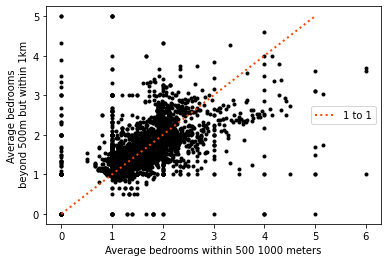

In [ ]:
plt.scatter(average_within_500,
            average_500m_to_1k,
            color='k', marker='.')
plt.xlabel("Average bedrooms within 500 1000 meters")
plt.ylabel("Average bedrooms\n beyond 500m but within 1km")
plt.plot([0,5],[0,5], color='orangered', linestyle=':', linewidth=2, 
         label='1 to 1')
plt.legend()

## Earthquake Catalog
This is an implementation of the [FDSN Event Web Service](http://www.fdsn.org/webservices/FDSN-WS-Specifications-1.0.pdf) Specification, and allows custom searches for earthquake information using a variety of parameters.

In [ ]:
#Import libraries
import requests

#parameters for the API using start and end dates
#Boundary for PR region
minlat = '0'
maxlat = '12'
minlon = '-78'
maxlon = '-74'

#date ranges 
sd = '2020-01-01T00:00:00'
ed = '2020-12-10T23:59:59'

#url 
url = ('https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&minlatitude='+ 
      minlat +'&maxlatitude='+ maxlat + '&minlongitude=' + minlon + '&maxlongitude=' + 
      maxlon + '&starttime=' + sd + '&endtime='+ ed)
#extract data
req = requests.get(url)
eq_data = req.json()

In [ ]:
print(url)

https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&minlatitude=0&maxlatitude=12&minlongitude=-78&maxlongitude=-74&starttime=2020-01-01T00:00:00&endtime=2020-12-10T23:59:59


In [ ]:
eq_data

In [ ]:
#get record count
rec_cnt = eq_data['metadata']['count']
eq_data = eq_data['features']
eq_list = []  #initializing list of dictionaries
for x in (list(range(0, rec_cnt))):            
    #getting event properties in a dictionary format
    eq_dict = {'id': eq_data[x]['id'] ,
              'time': eq_data[x]['properties']['time'],
              'updated': eq_data[x]['properties']['updated'],
              'title': eq_data[x]['properties']['title'],
              'mag': eq_data[x]['properties']['mag'], 
              'magType': eq_data[x]['properties']['magType'],            
              'lon': eq_data[x]['geometry']['coordinates'][0],
              'lat': eq_data[x]['geometry']['coordinates'][1],
              'depth': eq_data[x]['geometry']['coordinates'][2],
              'sources': eq_data[x]['properties']['sources'],
              'url': eq_data[x]['properties']['url']}
    eq_list.append(eq_dict)   
#save data into dataframe
df = pd.DataFrame(eq_list)

In [ ]:
df.head()

,id,time,updated,title,mag,magType,lon,lat,depth,sources,url
0,us7000cp26,1607397719906,1613169620040,"M 5.1 - 22 km SSW of Pizarro, Colombia",5.1,mww,-77.4135,4.7546,35.00,",us,",https://earthquake.usgs.gov/earthquakes/eventp...
1,us7000cli2,1606796434830,1612636164040,"M 4.4 - 10 km WSW of Murindó, Colombia",4.4,mb,-76.9087,6.9488,51.14,",us,",https://earthquake.usgs.gov/earthquakes/eventp...
2,us7000cked,1606263710838,1612636114040,"M 4.6 - 47 km NW of Pizarro, Colombia",4.6,mb,-77.6121,5.3100,10.00,",us,",https://earthquake.usgs.gov/earthquakes/eventp...
3,us6000cs48,1606244736274,1612374600040,"M 4.5 - 26 km WSW of Juradó, Colombia",4.5,mb,-77.9807,6.9956,10.00,",us,",https://earthquake.usgs.gov/earthquakes/eventp...
4,us7000cfn8,1605535161031,1611768595040,"M 4.8 - 15 km ENE of Sipí, Colombia",4.8,mb,-76.5228,4.7244,72.99,",us,",https://earthquake.usgs.gov/earthquakes/eventp...


In [ ]:
#data cleaning

#update time from unix timestamps to datetime
df['date_time'] = pd.to_datetime(pd.to_datetime(df.time, unit='ms',origin='unix'
                                      ).apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S")))
df['updated_datetime'] = pd.to_datetime(pd.to_datetime(df.updated, unit='ms',origin='unix'
                                             ).apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S")))
#magtype normalizing
df.magType = df.magType.str.upper()

#convert mag from str to numeric
df.mag = pd.to_numeric(df.mag)

#removing unnecesary columns
df.drop(columns = ['time','updated'], inplace = True)

In [ ]:
df.head()

,id,title,mag,magType,lon,lat,depth,sources,url,date_time,updated_datetime
0,us7000cp26,"M 5.1 - 22 km SSW of Pizarro, Colombia",5.1,MWW,-77.4135,4.7546,35.00,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,2020-12-08 03:21:59,2021-02-12 22:40:20
1,us7000cli2,"M 4.4 - 10 km WSW of Murindó, Colombia",4.4,MB,-76.9087,6.9488,51.14,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,2020-12-01 04:20:34,2021-02-06 18:29:24
2,us7000cked,"M 4.6 - 47 km NW of Pizarro, Colombia",4.6,MB,-77.6121,5.3100,10.00,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,2020-11-25 00:21:50,2021-02-06 18:28:34
3,us6000cs48,"M 4.5 - 26 km WSW of Juradó, Colombia",4.5,MB,-77.9807,6.9956,10.00,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,2020-11-24 19:05:36,2021-02-03 17:50:00
4,us7000cfn8,"M 4.8 - 15 km ENE of Sipí, Colombia",4.8,MB,-76.5228,4.7244,72.99,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,2020-11-16 13:59:21,2021-01-27 17:29:55


Now we need to get the earthquake data and assign a department. This will be done by checking if the epicenter coordinates lies inside any of the polygons. That is called a Point-in-Polygon (PIP): A spatial operation in which points from one feature dataset are overlaid on the polygons of another to determine which points are contained within the polygons.

First let’s get the earthquake data into a GeoDataFrame. The columns for latitude and longitude will be used to define a GeoSeries.

In [ ]:
#changing to a GeoDataFrame to create geometry series
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon,df.lat))

gdf.head()

,id,time,updated,title,mag,magType,lon,lat,depth,sources,url,geometry
0,us7000cp26,1607397719906,1613169620040,"M 5.1 - 22 km SSW of Pizarro, Colombia",5.1,mww,-77.4135,4.7546,35.00,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,POINT (-77.41350 4.75460)
1,us7000cli2,1606796434830,1612636164040,"M 4.4 - 10 km WSW of Murindó, Colombia",4.4,mb,-76.9087,6.9488,51.14,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,POINT (-76.90870 6.94880)
2,us7000cked,1606263710838,1612636114040,"M 4.6 - 47 km NW of Pizarro, Colombia",4.6,mb,-77.6121,5.3100,10.00,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,POINT (-77.61210 5.31000)
3,us6000cs48,1606244736274,1612374600040,"M 4.5 - 26 km WSW of Juradó, Colombia",4.5,mb,-77.9807,6.9956,10.00,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,POINT (-77.98070 6.99560)
4,us7000cfn8,1605535161031,1611768595040,"M 4.8 - 15 km ENE of Sipí, Colombia",4.8,mb,-76.5228,4.7244,72.99,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,POINT (-76.52280 4.72440)


In [ ]:
col = gpd.read_file("https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json")
col.head(2)

,DPTO,NOMBRE_DPT,AREA,PERIMETER,HECTARES,geometry
0,05,ANTIOQUIA,6.335186e+10,1963728.843,6335185.555,"POLYGON ((-76.30730 8.61930, -76.29810 8.61640..."
1,08,ATLANTICO,3.360765e+09,240936.172,336076.535,"POLYGON ((-74.87060 10.36120, -74.87640 10.343..."


<AxesSubplot:>

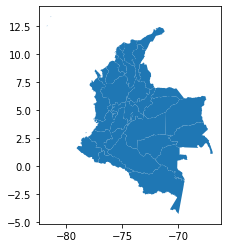

In [ ]:
col.plot()

In [ ]:
#identify those records from gdf that are intersecting with the region polygon
#this action will return a series with boolean values, if value is True it means the point 
#in that index location is within the polygon we are evaluating

pip = gdf.within(col.loc[0, 'geometry'])

#creating a new gdf keep only the intersecting records
so_pr = gdf.loc[pip].copy()

#assign region name 
so_pr['region'] = col.NOMBRE_DPT[0]

so_pr.head()

,id,time,updated,title,mag,magType,lon,lat,depth,sources,url,geometry,region
16,us70008l6q,1585797351206,1592700877040,"M 4.8 - 6 km WSW of Betania, Colombia",4.8,mww,-76.0317,5.724,86.86,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,POINT (-76.03170 5.72400),ANTIOQUIA


In [ ]:
def get_pip (gdf, regions):
    r_list = list(regions.NOMBRE_DPT)
    #create empty dataframe
    df = pd.DataFrame().reindex_like(gdf).dropna()
    for r in r_list:
        #get geometry for specific region
        pol = (regions.loc[regions.NOMBRE_DPT==r])
        pol.reset_index(drop = True, inplace = True)
        #identify those records from gdf that are intersecting with the region polygon
        pip_mask = gdf.within(pol.loc[0, 'geometry'])
        #filter gdf to keep only the intersecting records
        pip_data = gdf.loc[pip_mask].copy()
        #create a new column and assign the region name as the value
        pip_data['region']= r
        #append region data to empty dataframe
        df = df.append(pip_data)
    #checking there are no more than one region assigned to an event    
    print('Original dataframe count=',len(gdf),'\nNew dataframe count=', len(df))
    if df.loc[df.id.duplicated() == True].shape[0] > 0:
        print("There are id's with more than one region")
    #checking all events have a region
    elif gdf.loc[~gdf.id.isin(df.id)].shape[0] > 0:
        print("There are id's without an assigned region")
    else:
        print("No discrepancies in results!")
    df.reset_index(inplace=True, drop=True)
    df = df.drop(columns='geometry')
    return df

eq_df = get_pip(gdf, col)

Original dataframe count= 23 
New dataframe count= 13
There are id's without an assigned region


In [ ]:
eq_df

,id,time,updated,title,mag,magType,lon,lat,depth,sources,url,region
0,us70008l6q,1.585797e+12,1.592701e+12,"M 4.8 - 6 km WSW of Betania, Colombia",4.8,mww,-76.0317,5.7240,86.86,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,ANTIOQUIA
1,us70008y5u,1.587099e+12,1.594305e+12,"M 4.5 - 12 km SSW of Margarita, Colombia",4.5,mb,-74.3237,9.0600,47.34,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,BOLIVAR
2,us70008wpb,1.586948e+12,1.646889e+12,"M 5.7 - 13 km NNE of Pinillos, Colombia",5.7,mww,-74.4338,9.0335,53.00,",us,pt,",https://earthquake.usgs.gov/earthquakes/eventp...,BOLIVAR
3,us70009pgm,1.590323e+12,1.596911e+12,"M 4.5 - 6 km E of Morales, Colombia",4.5,mb,-76.5659,2.7483,10.00,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,CAUCA
4,us70009du7,1.589152e+12,1.596061e+12,"M 4.5 - 19 km NNW of Argelia, Colombia",4.5,mb,-77.3265,2.4112,92.49,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,CAUCA
5,us7000cli2,1.606796e+12,1.612636e+12,"M 4.4 - 10 km WSW of Murindó, Colombia",4.4,mb,-76.9087,6.9488,51.14,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,CHOCO
6,us7000cfn8,1.605535e+12,1.611769e+12,"M 4.8 - 15 km ENE of Sipí, Colombia",4.8,mb,-76.5228,4.7244,72.99,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,CHOCO
7,us6000c4r3,1.601334e+12,1.607202e+12,"M 4.6 - 5 km SSW of Istmina, Colombia",4.6,mb,-76.7076,5.1128,78.11,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,CHOCO
8,us70008uu4,1.586695e+12,1.593526e+12,"M 4.8 - 5 km S of Riosucio, Colombia",4.8,mb,-77.1263,7.3954,47.51,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,CHOCO
9,us70008rr0,1.585940e+12,1.592701e+12,"M 4.0 - 16 km NW of San José del Palmar, Colombia",4.0,mb,-76.3416,5.0023,134.53,",us,",https://earthquake.usgs.gov/earthquakes/eventp...,CHOCO


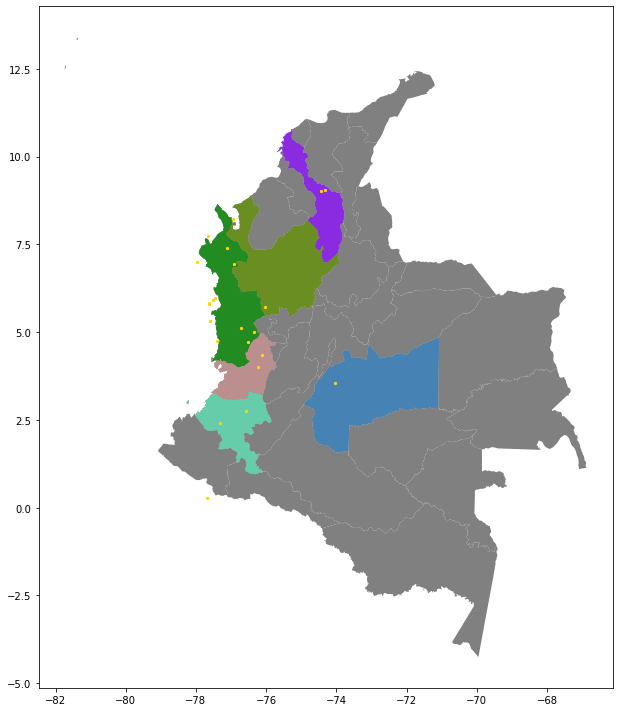

In [ ]:
# Plotting regions and earthquake data to show it on a map:

#importing libraries
import matplotlib.pyplot as plt

#list of colors to assign to each polygon, otherwise it will plot all of them in the same color

colors = ['forestgreen', 'steelblue','blueviolet','mediumaquamarine','olivedrab',
          'rosybrown','indianred']

#list of polygons in eq_df
regs = list(set(eq_df.region))


#list of all polygon names
polys = list(col.NOMBRE_DPT)

#plot region polygons and event points
fig, ax = plt.subplots(figsize=(10,10))
col.plot(ax=ax, facecolor='gray')

for i, reg in enumerate(regs):
    col.loc[col.NOMBRE_DPT==reg].plot(ax=ax, facecolor=colors[i])
    
gdf.plot(ax=ax, color='gold', markersize=5)

plt.tight_layout();